# **Обработка данных**

In [46]:
# Импортируем необходимые библиотеки
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications import vgg16, resnet50, mobilenet_v2, efficientnet
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.preprocessing import normalize
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Датасет: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

In [47]:
# Скачиваем датасет с Kaggle
import kagglehub
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-dataset' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-dataset


In [48]:
# Формируем путь к папке с датасетом
path = '/kaggle/input/fashion-product-images-dataset'
dataset_path = os.path.join(path, 'fashion-dataset')

In [10]:
df = pd.read_csv(os.path.join(dataset_path, 'styles.csv'), on_bad_lines='skip')
print("Форма датафрейма:", df.shape)
df.head()

Форма датафрейма: (44424, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


Датасет содержит 44 424 товара и включает следующие характеристики:
id (идентификатор), gender (пол), masterCategory (основная категория), subCategory (подкатегория), articleType (тип изделия), baseColour (основной цвет), season (сезон), year (год), usage (назначение), productDisplayName (название товара) - что позволяет детально анализировать ассортимент модной продукции.

In [11]:
# Удалим строки без изображения
df['image_path'] = df['id'].astype(str) + '.jpg'
df = df[df['image_path'].apply(lambda x: os.path.exists(os.path.join(dataset_path, 'images', x)))]
print("После фильтрации:", df.shape)

После фильтрации: (44419, 11)


Удалены строки, для которых отсутствуют соответствующие изображения товаров, поскольку визуальные признаки являются одной из ключевых составляющих разрабатываемой контентной рекомендательной системы. Наличие валидных изображений необходимо для корректного извлечения визуальных эмбеддингов с помощью моделей ResNet50, VGG16, MobileNetV2 и EfficientNetB0, а отсутствие изображений делало бы такие объекты непригодными для дальнейшего моделирования и сравнения товаров.

In [12]:
# Получаем общую информацию о датасете:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44419 entries, 0 to 44423
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44419 non-null  int64  
 1   gender              44419 non-null  object 
 2   masterCategory      44419 non-null  object 
 3   subCategory         44419 non-null  object 
 4   articleType         44419 non-null  object 
 5   baseColour          44404 non-null  object 
 6   season              44398 non-null  object 
 7   year                44418 non-null  float64
 8   usage               44102 non-null  object 
 9   productDisplayName  44412 non-null  object 
 10  image_path          44419 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.1+ MB


In [13]:
missing_percent = df.isnull().mean() * 100
print("Процент пропусков по столбцам:\n")
print(missing_percent)

Процент пропусков по столбцам:

id                    0.000000
gender                0.000000
masterCategory        0.000000
subCategory           0.000000
articleType           0.000000
baseColour            0.033769
season                0.047277
year                  0.002251
usage                 0.713659
productDisplayName    0.015759
image_path            0.000000
dtype: float64


Процент пропусков показывает, что большинство столбцов заполнены полностью, за исключением небольшого числа пропусков в baseColour, season, year, usage и productDisplayName.

In [14]:
df = df.dropna().reset_index(drop=True)

print("После удаления пропусков:", df.shape)

print("\nПроцент пропусков после очистки:")
print(df.isnull().mean() * 100)

После удаления пропусков: (44072, 11)

Процент пропусков после очистки:
id                    0.0
gender                0.0
masterCategory        0.0
subCategory           0.0
articleType           0.0
baseColour            0.0
season                0.0
year                  0.0
usage                 0.0
productDisplayName    0.0
image_path            0.0
dtype: float64


Пропуски были удалены, поскольку отсутствие информации о цвете, сезоне, назначении или названии товара мешает корректному формированию текстовых и категориальных признаков, необходимых для построения контентной рекомендательной системы. При этом удаление затронуло лишь небольшой процент записей, поэтому очищение данных не оказывает существенного влияния на репрезентативность набора и качество последующего моделирования.

In [15]:
# Проверяем, есть ли дубликаты по названию товара и по id
print(df.duplicated(subset='productDisplayName').sum())
print(df.duplicated(subset='id').sum())

13271
0


In [16]:
# Находим любое название, которое встречается несколько раз
dup_name = df['productDisplayName'].value_counts().idxmax()
dup_name

'Lucera Women Silver Earrings'

In [17]:
# Выводим все строки с этим названием
df[df['productDisplayName'] == dup_name]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
1445,48728,Women,Accessories,Jewellery,Earrings,Silver,Summer,2015.0,Casual,Lucera Women Silver Earrings,48728.jpg
1607,48717,Women,Accessories,Jewellery,Earrings,Silver,Summer,2012.0,Casual,Lucera Women Silver Earrings,48717.jpg
2031,48710,Women,Accessories,Jewellery,Earrings,Silver,Summer,2013.0,Casual,Lucera Women Silver Earrings,48710.jpg
2333,48726,Women,Accessories,Jewellery,Earrings,Silver,Summer,2015.0,Casual,Lucera Women Silver Earrings,48726.jpg
2656,48721,Women,Accessories,Jewellery,Earrings,Silver,Summer,2013.0,Casual,Lucera Women Silver Earrings,48721.jpg
...,...,...,...,...,...,...,...,...,...,...,...
39199,48593,Women,Accessories,Jewellery,Earrings,Silver,Summer,2012.0,Casual,Lucera Women Silver Earrings,48593.jpg
40742,48701,Women,Accessories,Jewellery,Earrings,Silver,Summer,2013.0,Casual,Lucera Women Silver Earrings,48701.jpg
42362,48592,Women,Accessories,Jewellery,Earrings,Silver,Summer,2013.0,Casual,Lucera Women Silver Earrings,48592.jpg
42822,48707,Women,Accessories,Jewellery,Earrings,Silver,Summer,2012.0,Casual,Lucera Women Silver Earrings,48707.jpg


После проверки наличия дубликатов в датасете обнаружено, что уникальные идентификаторы товаров не повторяются, но некоторые названия товаров встречаются несколько раз (например, «Lucera Women Silver Earrings» встречается 82 раза). Это показывает, что один и тот же продукт может быть представлен в разных экземплярах с разными ID или с небольшими вариациями характеристик.

In [21]:
# Статистическое описание столбца с годом выпуска товаров
df['year'].describe()

,year
count,44072.000000
mean,2012.781970
std,2.108125
min,2007.000000
25%,2011.000000
50%,2012.000000
75%,2015.000000
max,2019.000000


Год выпуска товаров варьируется от 2007 до 2019 года, с медианой в 2012 году, что показывает, что большинство товаров в наборе относятся к периоду примерно 2011–2015 годов.

In [22]:
# Все уникальные сезоны, указанные для товаров
df['season'].unique()

array(['Fall', 'Summer', 'Winter', 'Spring'], dtype=object)

В наборе данных представлены все четыре сезона — Fall, Summer, Winter, Spring, что позволяет учитывать сезонные особенности товаров при построении рекомендательной системы.

In [23]:
# Первые 20 уникальных значений основного цвета товаров
df['baseColour'].unique()[:20]

array(['Navy Blue', 'Blue', 'Silver', 'Black', 'Grey', 'Green', 'Purple',
       'White', 'Beige', 'Brown', 'Bronze', 'Teal', 'Copper', 'Pink',
       'Off White', 'Maroon', 'Red', 'Khaki', 'Orange', 'Yellow'],
      dtype=object)

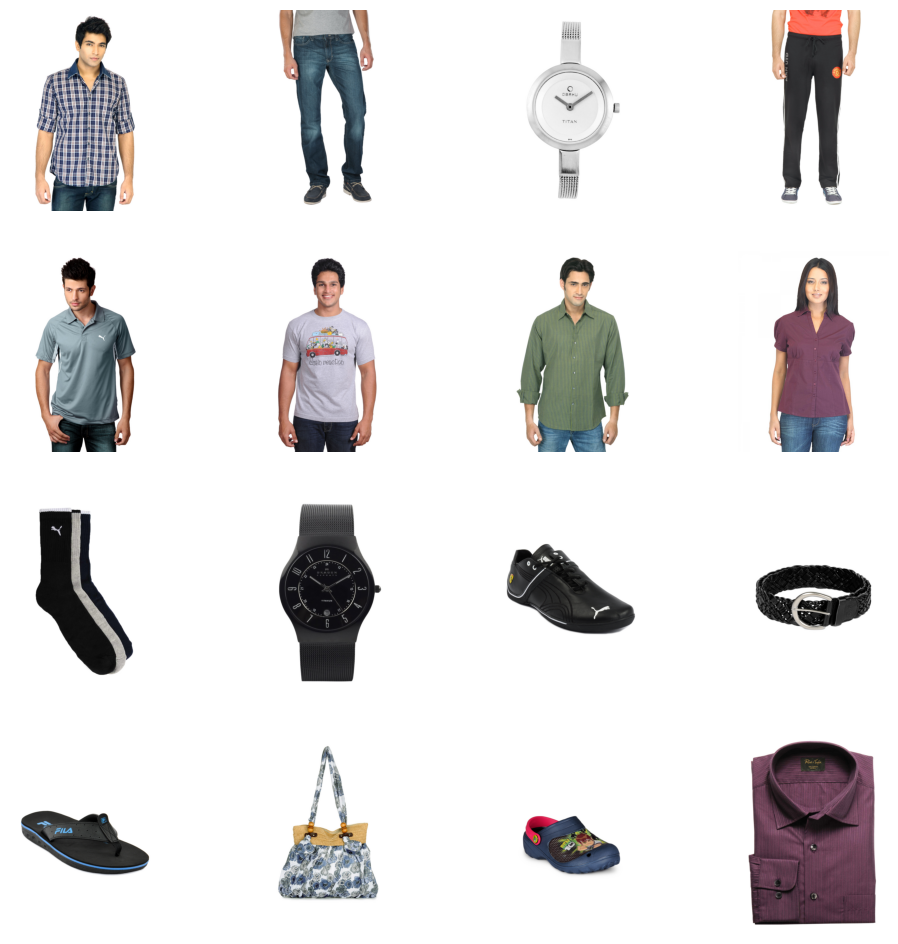

In [24]:
plt.figure(figsize=(12,12))

# Первые 16 изображений товаров для визуальной проверки
for i in range(16):
    img_path = os.path.join(dataset_path, "images", df['image_path'].iloc[i])  # путь к изображению
    img = Image.open(img_path)
    plt.subplot(4,4,i+1)       # размещаем изображение в сетке 4x4
    plt.imshow(img)
    plt.axis("off")
plt.show()

In [25]:
# Ширина и высота первого изображения в наборе
w, h = Image.open(os.path.join(dataset_path, 'images', df['image_path'].iloc[0])).size
print(w, h)

1800 2400


In [26]:
# Создаются очищенные названия товаров для последующей текстовой обработки
# Приводим все символы к нижнему регистру и удаляем знаки препинания и спецсимволы
df['clean_name'] = df['productDisplayName'].str.lower().apply(
    lambda x: re.sub(r'[^a-zа-я0-9\s]', '', x)
)

In [27]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path,clean_name
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,turtle check men navy blue shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,peter england men party blue jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,titan women silver watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,manchester united men solid black track pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,puma men grey tshirt


## **Визуальный анализ**

In [32]:
print("Уникальные категории:", df['gender'].unique())
print("Уникальные подкатегории:", df['subCategory'].nunique())

Уникальные категории: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
Уникальные подкатегории: 45


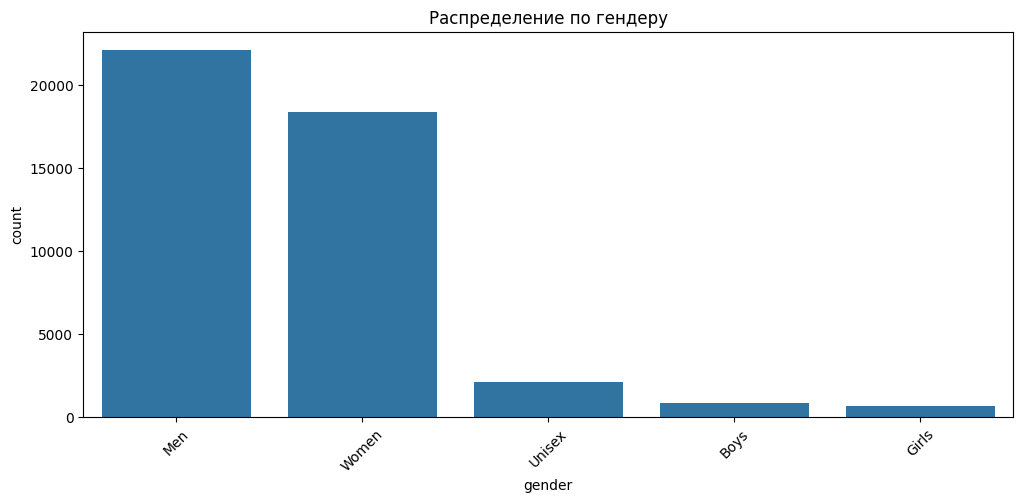

In [33]:
# Распределение категорий
plt.figure(figsize=(12,5))
sns.countplot(data=df, x='gender', order=df['gender'].value_counts().index) # строим столбчатую диаграмму по полу
plt.title('Распределение по гендеру')
plt.xticks(rotation=45)
plt.show()

Большинство товаров в наборе предназначены для мужчин и женщин, а доля товаров для унисекс, мальчиков и девочек существенно меньше, что отражает дисбаланс по гендерной категории.

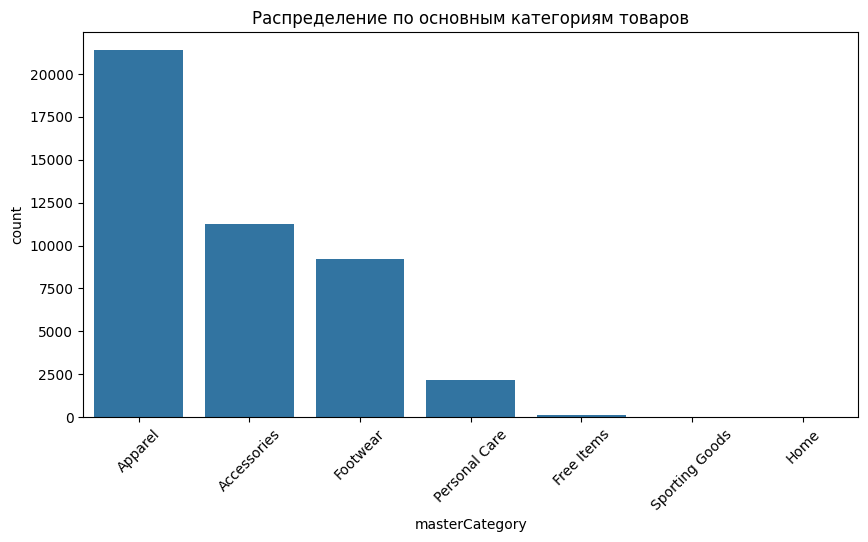

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='masterCategory', order=df['masterCategory'].value_counts().index) # столбчатая диаграмма по категориям товаров
plt.title('Распределение по основным категориям товаров')
plt.xticks(rotation=45)
plt.show()

Наибольшее количество товаров представлено в категории «Apparel», за ней следуют «Accessories» и «Footwear». Остальные категории («Personal Care», «Free Items», «Sporting Goods», «Home») встречаются значительно реже. Это говорит о том, что при построении рекомендательной системы основной фокус следует делать на одежде и аксессуарах, так как они составляют большую часть ассортимента интернет-магазина.

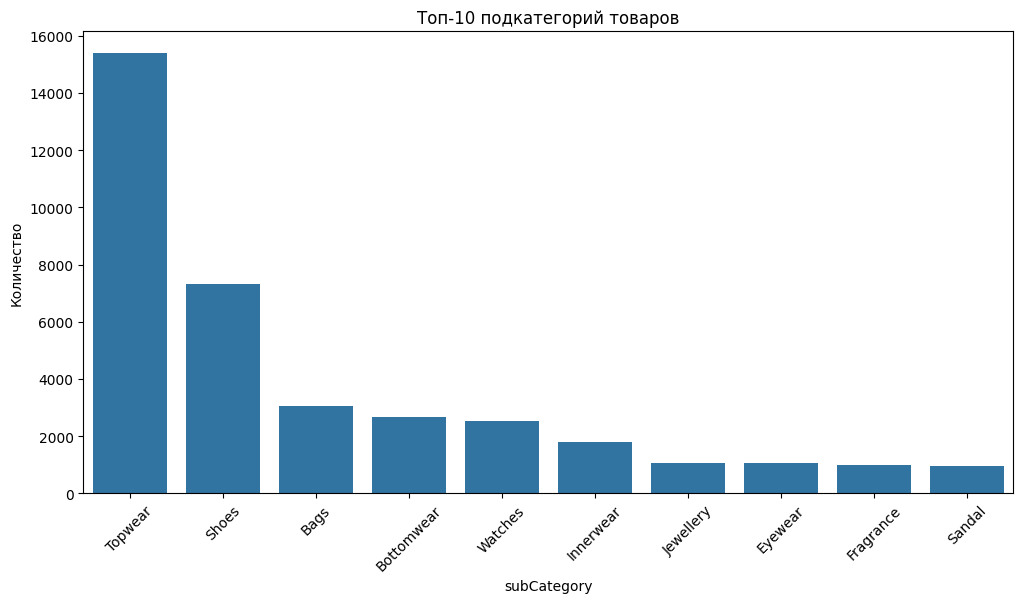

In [ ]:
plt.figure(figsize=(12,6))
top_sub = df['subCategory'].value_counts().head(10) # топ-10 подкатегорий
sns.barplot(x=top_sub.index, y=top_sub.values) # строим столбчатую диаграмму
plt.title('Топ-10 подкатегорий товаров')
plt.xticks(rotation=45)
plt.ylabel('Количество')
plt.show()

Наибольшее количество товаров представлено в категориях Topwear и Shoes, что указывает на их ключевое значение при построении рекомендательной системы. Менее представленные категории, такие как Fragrance, Sandal и Eyewear, могут оказывать меньшее влияние на качество рекомендаций при использовании категориальных признаков, однако их учет важен для обеспечения полноты рекомендаций.

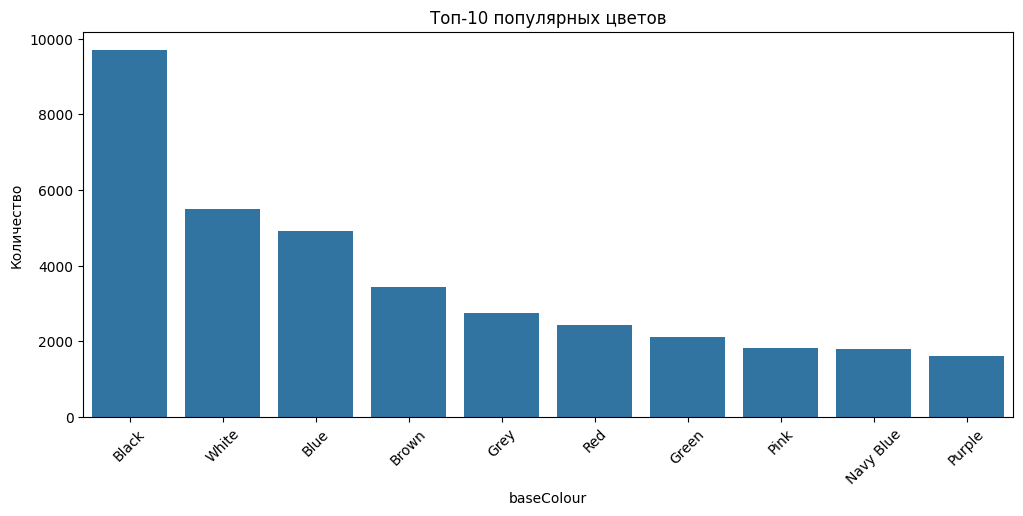

In [ ]:
plt.figure(figsize=(12,5))
top_colors = df['baseColour'].value_counts().head(10) # топ-10 популярных цветов
sns.barplot(x=top_colors.index, y=top_colors.values) # строим столбчатую диаграмму
plt.title('Топ-10 популярных цветов')
plt.xticks(rotation=45)
plt.ylabel('Количество')
plt.show()

Люди чаще всего выбирают черное и белое, но и про другие цвета забывать нельзя. Их нужно учитывать, чтобы предлагать необычные вещи тем, кто ищет что-то особенное. Это сделает рекомендации точнее и полезнее для всех.


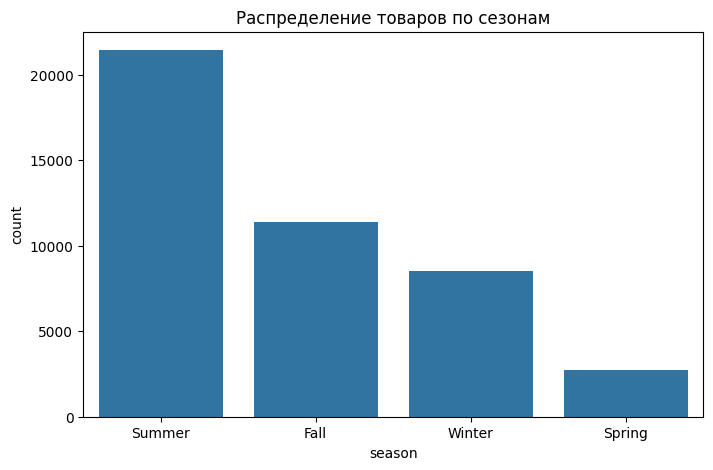

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='season', order=df['season'].value_counts().index) # столбчатая диаграмма по сезонам
plt.title('Распределение товаров по сезонам')
plt.show()

По графику видно, что большинство товаров в магазине - для сезонов лето и осень. Товары для весны и зимы встречаются реже, но их тоже важно учитывать, чтобы система могла предлагать сезонные варианты.

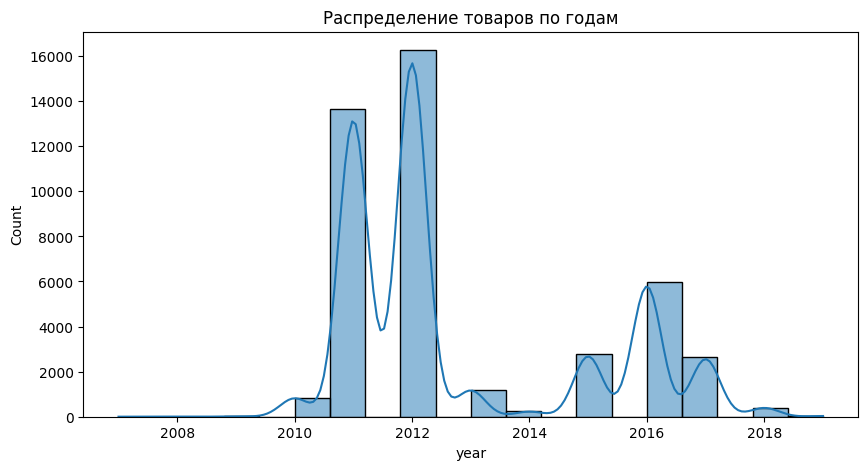

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(data=df, x='year', bins=20, kde=True) # гистограмма с плотностью распределения по годам
plt.title('Распределение товаров по годам')
plt.show()

Как описывалось ранее, год выпуска товаров варьируется от 2007 до 2019 года, с медианой в 2012 году, что показывает, что большинство товаров в наборе относятся к периоду примерно 2011–2015 годов.

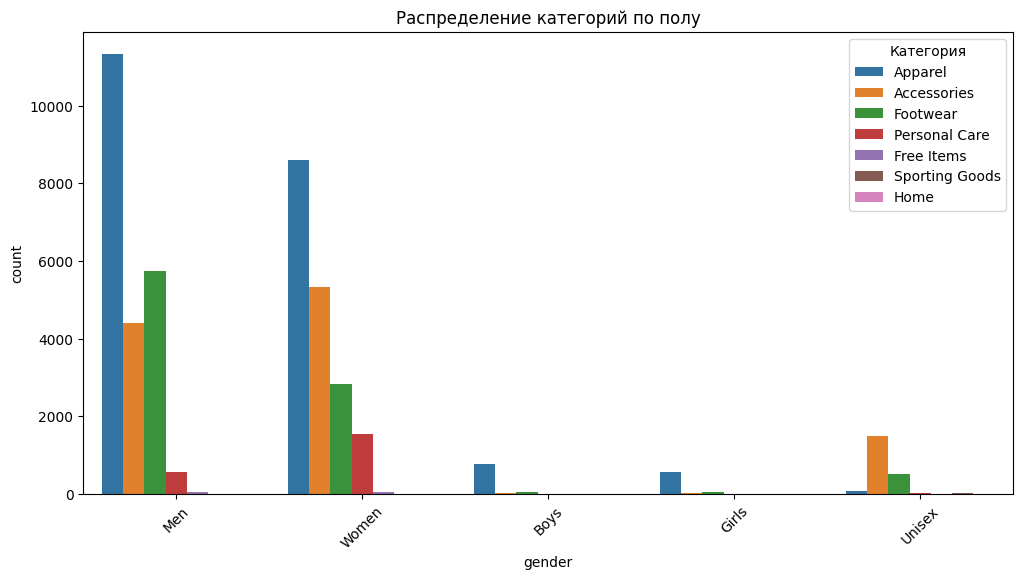

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='gender', hue='masterCategory') # столбчатая диаграмма с разбивкой по категориям
plt.title('Распределение категорий по полу')
plt.xticks(rotation=45)
plt.legend(title='Категория')
plt.show()

Мужская одежда преобладает в Apparel и Footwear, а женская — в Apparel и Accessories.

# **Бейзлайн**

In [45]:
def recommend_baseline_random(query_name, df, top_k=5, random_state=42):
    # Бейзлайн: случайные товары из той же подкатегории
    np.random.seed(random_state)
    # Определяем подкатегорию товара-запроса
    query_subcat = df.loc[df['productDisplayName'] == query_name, 'subCategory'].values[0]
    subcat_items = df[df['subCategory'] == query_subcat].copy()

    # Оставляем уникальные товары по названию
    unique_items = subcat_items.drop_duplicates(subset='productDisplayName')

    # Случайный выбор top_k товаров
    if len(unique_items) <= top_k:
        top_items = unique_items['productDisplayName'].tolist()
    else:
        top_items = np.random.choice(unique_items['productDisplayName'], size=top_k, replace=False).tolist()

    # Формируем результат без лишних столбцов
    result = unique_items[unique_items['productDisplayName'].isin(top_items)].copy()

    # Удаляем столбец clean_name
    result = result.drop(columns=['clean_name'])

    return result.reset_index(drop=True)

query = "Puma Men Future Cat Remix SF Black Casual Shoes"
baseline_random = recommend_baseline_random(query, df, top_k=5)
baseline_random

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,5899,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2011.0,Casual,Puma Men's Mid Spill Black Shoe,5899.jpg
1,31216,Men,Footwear,Shoes,Casual Shoes,White,Summer,2012.0,Casual,Lotto Men Fella Tres White Casual Shoes,31216.jpg
2,17845,Men,Footwear,Shoes,Sports Shoes,White,Fall,2011.0,Sports,Nike Men T90 Shoot I\/ HG-B White Sports Shoe,17845.jpg
3,19053,Unisex,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Unisex Black Hip Hop Shoes,19053.jpg
4,22979,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2012.0,Casual,Fila Men Black New Percoso II Casual Shoes,22979.jpg


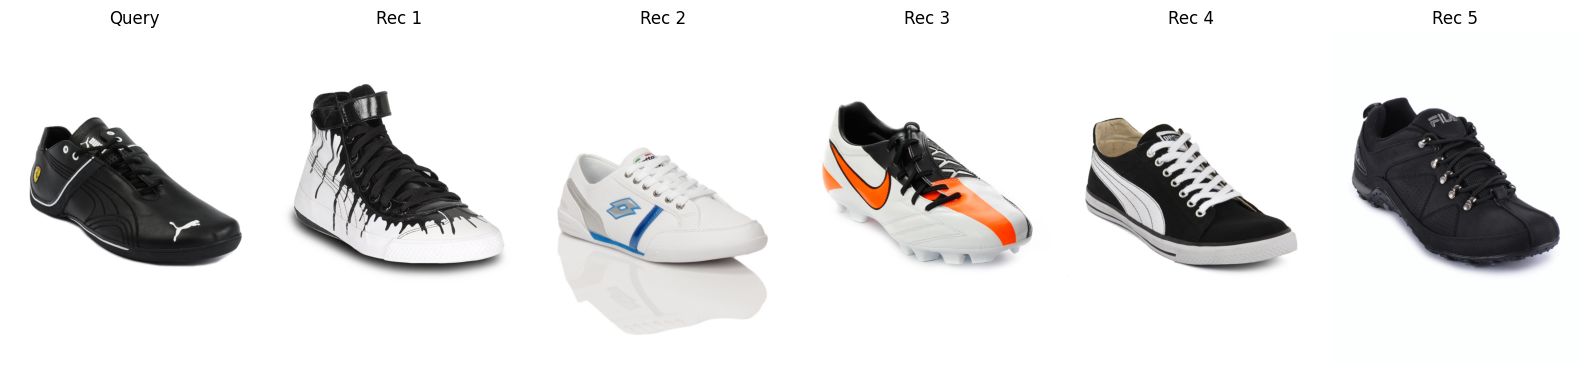

In [44]:
top_k = 5

def visualize_baseline_with_images(query_name, df, dataset_path, top_k=5, random_state=42):
    # Визуализирует товар-запрос слева и 5 случайных рекомендаций справа
    # Получаем рекомендации бейзлайна
    recommended = recommend_baseline_random(query_name, df, top_k=top_k, random_state=random_state)

    # Визуализация
    fig = plt.figure(figsize=(16, 4))

    # Изображение товара-запроса
    query_img_path = df.loc[df['productDisplayName'] == query_name, 'image_path'].values[0]
    img = Image.open(os.path.join(dataset_path, "images", query_img_path))
    ax = fig.add_subplot(1, top_k+1, 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Query")

    # Изображения рекомендаций
    for i, img_path in enumerate(recommended['image_path'], start=2):
        img = Image.open(os.path.join(dataset_path, "images", img_path))
        ax = fig.add_subplot(1, top_k+1, i)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Rec {i-1}")

    plt.tight_layout()
    plt.show()
    return None

query = "Puma Men Future Cat Remix SF Black Casual Shoes"
visualize_baseline_with_images(query, df, dataset_path, top_k=5)

Бейзлайн выдаёт случайные товары из той же подкатегории, поэтому некоторые из рекомендованных товаров могут совпадать с запросом хотя бы по цвету или типу, но другие сильно отличаются по стилю, форме или дизайну. В отличие от этого, модели контентной фильтрации учитывают визуальные и текстовые признаки, что позволяет получать рекомендации, которые более точно соответствуют внешнему виду, стилю и смыслу товара, обеспечивая высокую персонализацию и улучшая качество рекомендаций.

# **Визуальные модели**

ResNet50, VGG16 и MobileNetV2

In [ ]:
def extract_features(model_name, img_paths, dataset_path, target_size=(224,224), batch_size=32):
    # Извлекает эмбеддинги изображений из предобученной CNN
    # Выбор предобученной модели и функции предобработки
    if model_name.lower() == 'resnet50':
        base_model = resnet50.ResNet50(weights='imagenet', include_top=False, pooling='avg')
        preprocess = resnet50.preprocess_input
    elif model_name.lower() == 'vgg16':
        base_model = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
        preprocess = vgg16.preprocess_input
    elif model_name.lower() == 'mobilenetv2':
        base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
        preprocess = mobilenet_v2.preprocess_input
    elif model_name.lower() == 'efficientnetb0':
        base_model = efficientnet.EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
        preprocess = efficientnet.preprocess_input

    features = []
    for path in tqdm(img_paths):  # перебор всех изображений
        img = load_img(os.path.join(dataset_path, 'images', path), target_size=target_size)  # загрузка и ресайз
        x = img_to_array(img)  # конвертация в массив
        x = np.expand_dims(x, axis=0)  # добавление батч-оси
        x = preprocess(x)  # предобработка для модели
        feat = base_model.predict(x, verbose=0)  # извлечение признаков
        features.append(feat.flatten())  # преобразование в вектор

    features = np.array(features)  # конвертация списка в массив
    features = features / np.linalg.norm(features, axis=1, keepdims=True)  # нормализация векторов
    return features  # возвращаем эмбеддинги

In [ ]:
# список путей к изображениям
img_paths = df['image_path'].tolist()

In [ ]:
models = ['resnet50', 'vgg16', 'mobilenetv2', 'efficientnetb0']  # список моделей для извлечения признаков
features_dict = {}  # словарь для хранения эмбеддингов каждой модели

for m in models:
    print(f"Извлечение объектов с помощью {m}...")  # вывод текущей модели
    features_dict[m] = extract_features(m, img_paths, dataset_path)  # извлечение и сохранение эмбеддингов

Извлечение объектов с помощью resnet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 44072/44072 [1:24:04<00:00,  8.74it/s]


Извлечение объектов с помощью vgg16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 44072/44072 [1:24:24<00:00,  8.70it/s]


Извлечение объектов с помощью mobilenetv2...


/tmp/ipython-input-3876842721.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 44072/44072 [1:18:05<00:00,  9.41it/s]


Извлечение объектов с помощью efficientnetb0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


100%|██████████| 44072/44072 [1:18:54<00:00,  9.31it/s]


In [ ]:
# Сохраняем эмбеддинги моделей
np.save("resnet50_features.npy", features_dict['resnet50'])
np.save("vgg16_features.npy", features_dict['vgg16'])
np.save("mobilenetv2_features.npy", features_dict['mobilenetv2'])
np.save("efficientnetb0_features.npy", features_dict['efficientnetb0'])

In [ ]:
!pip install faiss-cpu -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 18.1 MB/s eta 0:00:00


In [ ]:
import faiss

top_k = 5  # топ-K соседей

# Метрики через FAISS

def faiss_topk_cosine(features, k=top_k):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация векторов для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])  # индекс для inner product (косинус)
    index.add(features)  # добавляем векторы в индекс
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей (+1 чтобы исключить себя)
    similarities = distances[:, 1:]  # пропускаем самого себя
    return similarities.mean()  # возвращаем среднюю схожесть

def faiss_hit_rate_at_k(features, labels, k=5):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)
    _, indices = index.search(features, k+1)  # индексы соседей

    hits = 0
    labels_array = labels.to_numpy()

    for i in range(len(features)):
        neigh_idx = indices[i][1:]  # исключаем самого себя
        if labels_array[i] in labels_array[neigh_idx]:  # проверка попадания в топ-K
            hits += 1

    return hits / len(features)  # доля попаданий (hit rate)

def faiss_topk_euclidean(features, k=top_k):
    features = features.astype('float32')
    index = faiss.IndexFlatL2(features.shape[1])  # индекс для евклидова расстояния
    index.add(features)  # добавляем векторы в индекс
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей
    return distances[:, 1:].mean()  # среднее расстояние (без себя)

In [ ]:
# Загрузка эмбеддингов моделей
features_dict = {
    'resnet50': np.load("/content/resnet50_features.npy"),
    'vgg16': np.load("/content/vgg16_features.npy"),
    'mobilenetv2': np.load("/content/mobilenetv2_features.npy"),
    'efficientnetb0': np.load("/content/efficientnetb0_features.npy")
}

summary = []

for m in tqdm(models, desc="Processing models"):  # перебор моделей с индикатором прогресса
    feats = features_dict[m].astype('float32')  # приведение к float32
    avg_cos = faiss_topk_cosine(feats)  # средняя косинусная схожесть топ-5
    hit5 = faiss_hit_rate_at_k(feats, df["subCategory"], k=top_k)  # hit rate @5 по подкатегориям
    avg_euc = faiss_topk_euclidean(feats)  # среднее евклидово расстояние топ-5

    summary.append({
        "Модель": m,
        "Average Top-5 Cosine": avg_cos,
        "HitRate@5": hit5,
        "Average Top-5 Euclidean": avg_euc
    })  # добавляем результаты в список

summary_df = pd.DataFrame(summary)

Processing models: 100%|██████████| 4/4 [19:00<00:00, 285.05s/it]


In [ ]:
summary_df

,Модель,Average Top-5 Cosine,HitRate@5,Average Top-5 Euclidean
0,resnet50,0.881241,0.987475,0.237519
1,vgg16,0.897739,0.987793,0.204521
2,mobilenetv2,0.831522,0.988042,0.336956
3,efficientnetb0,0.829021,0.990493,0.341958


ResNet50 и VGG16 показали наилучшие результаты по Average Top-5 Cosine (0.881 и 0.898) и высокие HitRate@5 (~0.988), подтверждая их эффективность для извлечения визуальных признаков товаров. MobileNetV2 и EfficientNetB0 чуть уступают по косинусной схожести, но сохраняют высокую точность рекомендаций. В дальнейшем для построения рекомендательной системы будет выбрана модель VGG16 как наиболее оптимальная по качеству признаков.

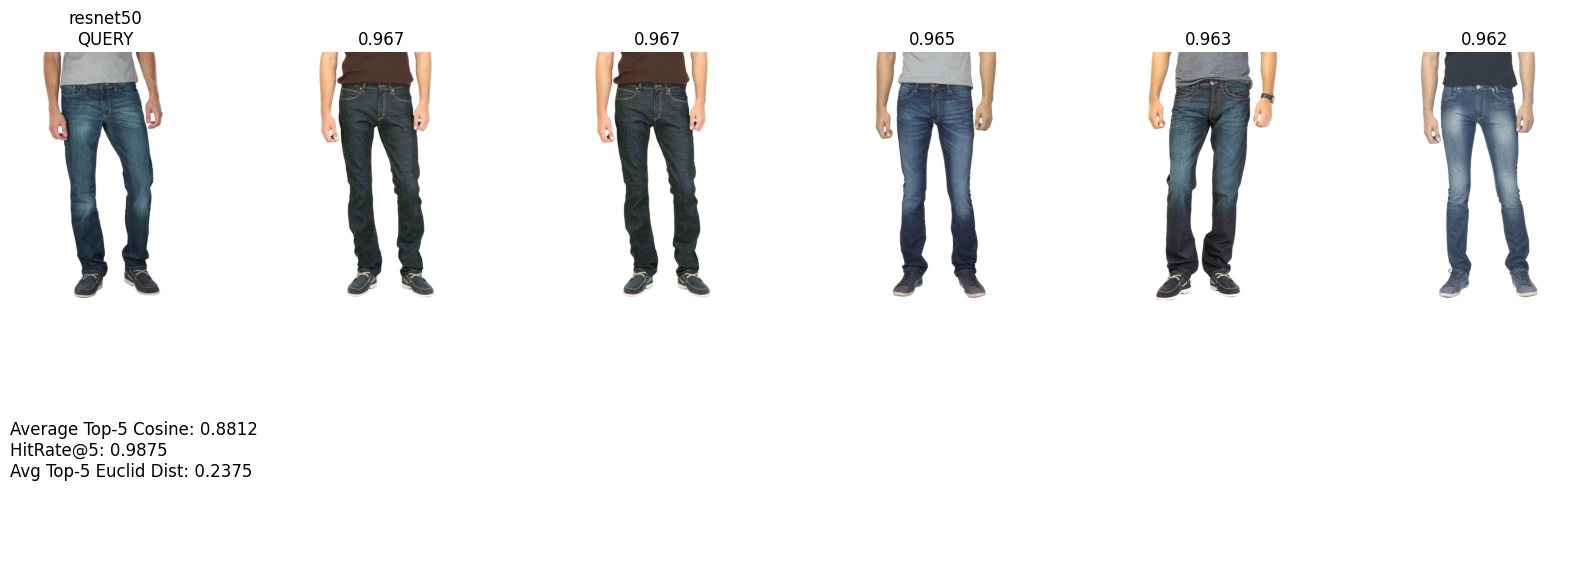

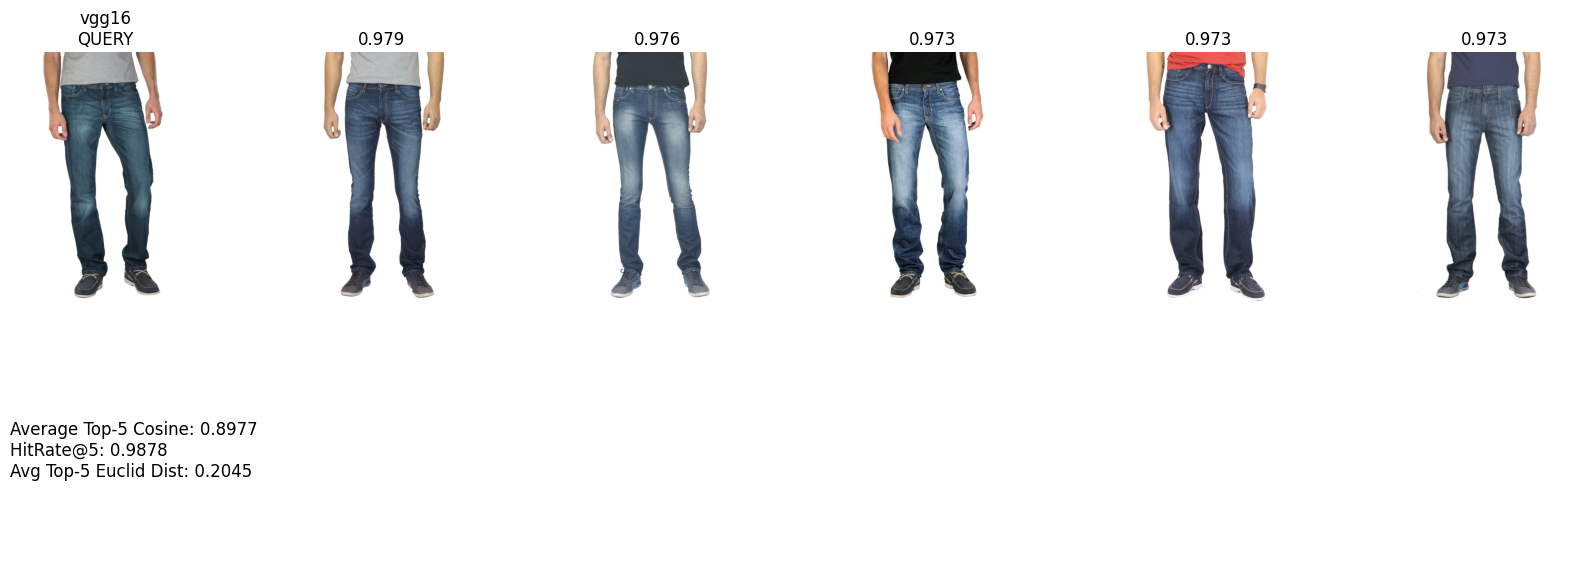

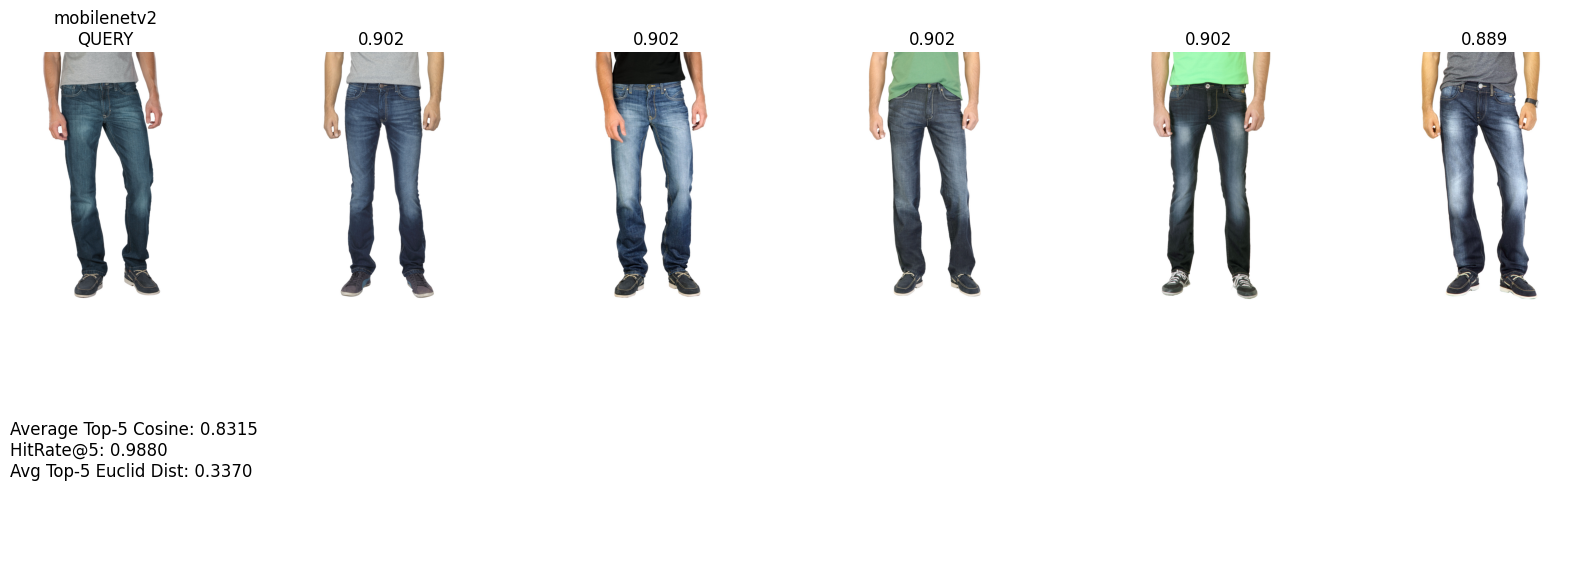

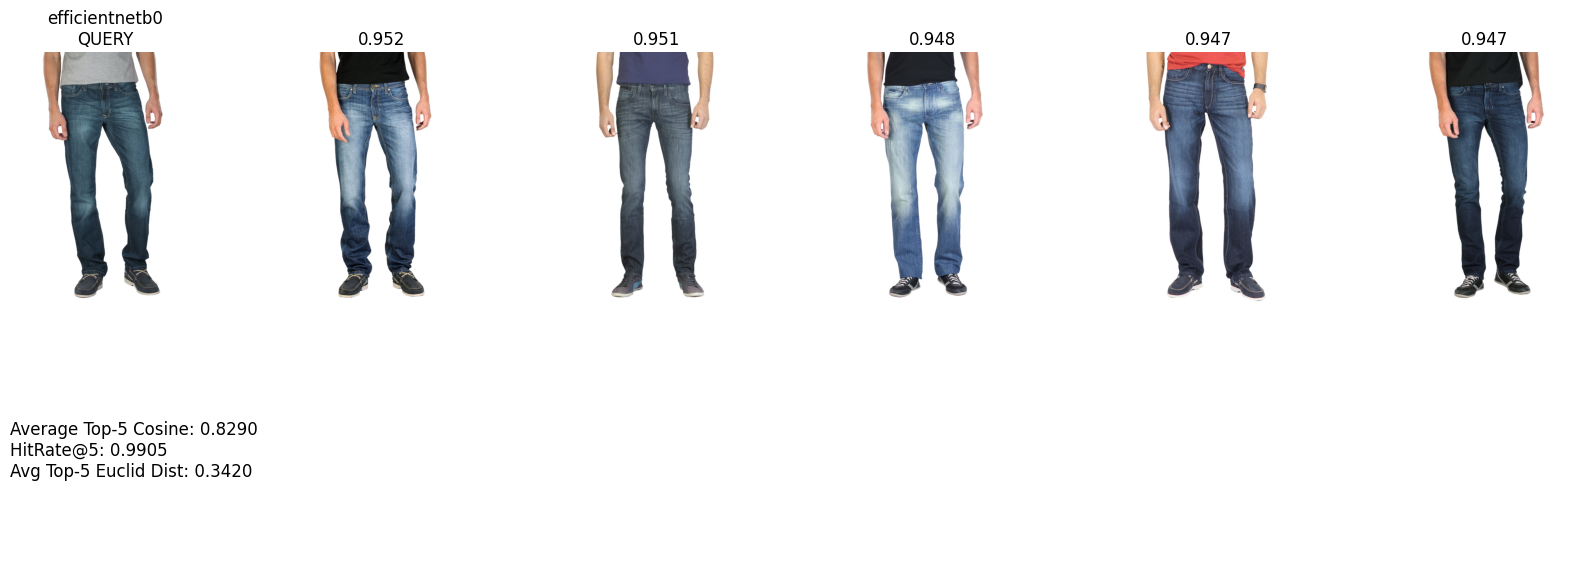

In [ ]:
metrics_dict = {}
for _, row in summary_df.iterrows():
    metrics_dict[row["Модель"]] = {  # создаём словарь метрик для каждой модели
        "cosine": row["Average Top-5 Cosine"],
        "hit": row["HitRate@5"],
        "euclid": row["Average Top-5 Euclidean"]
    }

def visualize_model_results(model_name, features, img_paths, metrics_dict, query_index=0, dataset_path=dataset_path):
    # Вычисляем косинусное сходство с выбранным изображением-запросом
    sims = cosine_similarity([features[query_index]], features)[0]
    top_idx = sims.argsort()[-6:][::-1]  # индексы 6 наибольших значений (включая сам запрос)
    top_idx = top_idx[1:6]               # оставляем 5 похожих изображений

    fig = plt.figure(figsize=(16, 6))

    # Отображаем изображение-запрос
    ax = fig.add_subplot(2, 6, 1)
    img = Image.open(os.path.join(dataset_path, 'images', img_paths[query_index]))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{model_name}\nQUERY")

    # Отображаем 5 похожих изображений
    for i, idx in enumerate(top_idx):
        ax = fig.add_subplot(2, 6, i + 2)
        img = Image.open(os.path.join(dataset_path, 'images', img_paths[idx]))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{sims[idx]:.3f}")  # подпись с косинусной схожестью

    # Отображаем метрики модели
    text = (
        f"Average Top-5 Cosine: {metrics_dict[model_name]['cosine']:.4f}\n"
        f"HitRate@5: {metrics_dict[model_name]['hit']:.4f}\n"
        f"Avg Top-5 Euclid Dist: {metrics_dict[model_name]['euclid']:.4f}"
    )
    ax = fig.add_subplot(2, 6, 7)
    ax.axis('off')
    ax.text(0.0, 0.5, text, fontsize=12, va='center')

    plt.tight_layout()
    plt.show()  # показываем визуализацию

def visualize_all_models(models, features_dict, img_paths, metrics_dict, query_index=0, dataset_path=dataset_path):
    for model_name in models:
        visualize_model_results(  # отображаем результаты для каждой модели
            model_name=model_name,
            features=features_dict[model_name],
            img_paths=img_paths,
            metrics_dict=metrics_dict,
            query_index=query_index,
            dataset_path=dataset_path
        )

# визуализация рекомендаций для выбранного изображения (query_index=1)
visualize_all_models(models, features_dict, df['image_path'].tolist(), metrics_dict, query_index=1)

Визуализация рекомендаций подтверждает, что VGG16 обеспечивает наилучшее качество поиска похожих товаров: наиболее релевантные изображения имеют высокую косинусную схожесть с изображением-запросом, что согласуется с ранее рассчитанными метриками Average Top-5 Cosine и HitRate@5.

In [ ]:
visual_feats = features_dict['vgg16']  # используем ранее извлечённые признаки
visual_feats = normalize(visual_feats)  # нормализация для корректного сравнения

# **Текстовые признаки**

In [ ]:
top_k = 5  # количество ближайших соседей для рекомендаций

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # векторизация текста с униграммами и биграммами
tfidf_feats = tfidf.fit_transform(df['clean_name']).toarray()  # преобразуем названия товаров в TF-IDF векторы
tfidf_feats = normalize(tfidf_feats)  # нормализация векторов для корректного сравнения

In [ ]:
! pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 19.6 MB/s eta 0:00:00


In [ ]:
import gensim
from gensim.models import Word2Vec

sentences = [text.split() for text in df['clean_name']]  # разбиение названий товаров на слова
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)  # обучение Word2Vec модели

def get_w2v_vector(text):
    words = text.split()
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]  # получение векторов слов
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)  # пустой вектор, если слов нет в словаре
    return np.mean(vecs, axis=0)  # усреднение векторов слов для представления текста

w2v_feats = np.array([get_w2v_vector(text) for text in df['clean_name']])  # создаем векторы для всех товаров
w2v_feats = normalize(w2v_feats)  # нормализация векторов

In [ ]:
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # загрузка предобученной модели Sentence-BERT
sbert_feats = sbert_model.encode(df['clean_name'].tolist(), batch_size=32, show_progress_bar=True)  # кодирование названий товаров в векторы
sbert_feats = normalize(sbert_feats)  # нормализация векторов для корректного сравнения

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1378 [00:00<?, ?it/s]

In [ ]:
def faiss_hit_rate_at_k(features, labels, k=top_k):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация векторов для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])  # индекс для inner product
    index.add(features)  # добавляем векторы в индекс
    _, indices = index.search(features, k+1)  # поиск k+1 соседей (включая себя)

    hits = 0
    labels_array = labels.to_numpy()

    for i in range(len(features)):
        neigh_idx = indices[i][1:]  # исключаем самого себя
        if labels_array[i] in labels_array[neigh_idx]:  # проверка попадания в топ-K
            hits += 1
    return hits / len(features)  # доля попаданий (HitRate@k)

def faiss_topk_cosine(features, k=top_k):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)  # добавляем векторы в индекс
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей
    return distances[:, 1:].mean()  # средняя косинусная схожесть без самого себя

def faiss_topk_euclidean(features, k=top_k):
    features = features.astype('float32')
    index = faiss.IndexFlatL2(features.shape[1])  # индекс для евклидового расстояния
    index.add(features)  # добавляем векторы
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей
    return distances[:, 1:].mean()  # среднее расстояние без самого себя

Метрики, на которые стоит смотреть:

HitRate@5 - Практическая метрика для рекомендаций: показывает, что среди 5 ближайших соседей хотя бы один относится к той же подкатегории. Отлично отражает, насколько реально полезна система для пользователя.

Average Top-5 Cosine - Косинусное сходство хорошо показывает семантическое качество эмбеддингов, особенно для Word2Vec и Sentence-BERT. Векторные модели текста ориентированы именно на направления в пространстве, поэтому косинусная мера здесь важнее, чем евклидово расстояние.

Метрика, на которую не стоит сильно ориентироваться:

Average Top-5 Euclidean - Для TF-IDF и Word2Vec евклидово расстояние может быть обманчивым, потому что длина вектора сильно влияет на результат. Для предобученных BERT/Transformer моделей косинус обычно более информативен. Можно посчитать для полноты и сравнения с визуальными эмбеддингами, но не делать на нём основной вывод.

In [ ]:
text_models = {
    'TF-IDF': tfidf_feats.astype('float32'),       # векторы TF-IDF
    'Word2Vec': w2v_feats.astype('float32'),      # векторы Word2Vec
    'Sentence-BERT': sbert_feats.astype('float32') # векторы Sentence-BERT
}

summary = []
for name, feats in tqdm(text_models.items(), desc="Processing text models"):  # перебор текстовых моделей с прогрессом
    avg_cos = faiss_topk_cosine(feats)  # средняя косинусная схожесть топ-5
    hit5 = faiss_hit_rate_at_k(feats, df['subCategory'], k=top_k)  # HitRate@5 по подкатегориям
    avg_euc = faiss_topk_euclidean(feats)  # среднее евклидово расстояние топ-5
    summary.append({
        "Text Model": name,
        "Average Top-5 Cosine": avg_cos,
        "HitRate@5": hit5,
        "Average Top-5 Euclidean": avg_euc
    })  # добавляем результаты в список

summary_df = pd.DataFrame(summary)
summary_df

Processing text models: 100%|██████████| 3/3 [19:07<00:00, 382.58s/it]


,Text Model,Average Top-5 Cosine,HitRate@5,Average Top-5 Euclidean
0,TF-IDF,0.809928,0.988587,0.378374
1,Word2Vec,0.993696,0.984072,0.012608
2,Sentence-BERT,0.920814,0.995144,0.158373


Анализ текстовых эмбеддингов показал, что наилучшие результаты достигаются при использовании Sentence-BERT: HitRate@5 составил 0.995, что выше, чем у TF-IDF и Word2Vec. Косинусное сходство также высокое, что свидетельствует о качественном семантическом разделении товаров. Таким образом, для построения комбинированной Content-Based рекомендательной системы целесообразно использовать именно Sentence-BERT в качестве текстового признака.

На всех текстовых признаках

In [ ]:
text_cols = ['clean_name', 'subCategory', 'articleType', 'baseColour', 'usage']
df['full_text'] = df[text_cols].astype(str).agg(' '.join, axis=1)  # объединяем текстовые и категориальные признаки в один столбец

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # TF-IDF с униграммами и биграммами
tfidf_feats = tfidf.fit_transform(df['full_text']).toarray()   # преобразуем объединённый текст в векторы
tfidf_feats = normalize(tfidf_feats)                            # нормализация векторов для корректного сравнения

In [ ]:
sentences = [text.split() for text in df['full_text']]  # разбиение объединённого текста на слова
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)  # обучение Word2Vec на полном тексте

def get_w2v_vector(text):
    words = text.split()
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]  # получаем векторы слов
    if len(vecs) == 0:
        return np.zeros(w2v_model.vector_size)  # пустой вектор, если слов нет в словаре
    return np.mean(vecs, axis=0)  # усреднение векторов слов для представления текста

w2v_feats = np.array([get_w2v_vector(text) for text in df['full_text']])  # создаём векторы для всех товаров
w2v_feats = normalize(w2v_feats)  # нормализация векторов

In [ ]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')  # загрузка предобученной модели Sentence-BERT
sbert_feats = sbert_model.encode(df['full_text'].tolist(), batch_size=32, show_progress_bar=True)  # кодирование объединённого текста в векторы
sbert_feats = normalize(sbert_feats)  # нормализация векторов для корректного сравнения

Batches:   0%|          | 0/1378 [00:00<?, ?it/s]

In [ ]:
# Векторы моделей на полном тексте
text_models = {
    'TF-IDF': tfidf_feats.astype('float32'),
    'Word2Vec': w2v_feats.astype('float32'),
    'Sentence-BERT': sbert_feats.astype('float32')
}

summary = []
for name, feats in tqdm(text_models.items(), desc="Processing text models"):  # перебор моделей с индикатором прогресса
    avg_cos = faiss_topk_cosine(feats)  # средняя косинусная схожесть топ-5
    hit5 = faiss_hit_rate_at_k(feats, df['subCategory'], k=top_k)  # HitRate@5 по подкатегориям
    avg_euc = faiss_topk_euclidean(feats)  # среднее евклидово расстояние топ-5
    summary.append({
        "Text Model": name,
        "Average Top-5 Cosine": avg_cos,
        "HitRate@5": hit5,
        "Average Top-5 Euclidean": avg_euc
    })  # добавляем результаты для каждой модели

summary_df = pd.DataFrame(summary)
summary_df

Processing text models: 100%|██████████| 3/3 [19:01<00:00, 380.51s/it]


,Text Model,Average Top-5 Cosine,HitRate@5,Average Top-5 Euclidean
0,TF-IDF,0.848613,0.999002,0.302774
1,Word2Vec,0.992660,0.998843,0.014680
2,Sentence-BERT,0.940287,0.997913,0.119426


Все три модели дают хорошие рекомендации, но Word2Vec показывает наивысшее косинусное сходство, TF-IDF немного хуже по семантическому разделению, а Sentence-BERT демонстрирует хороший баланс между HitRate и семантической точностью. Для комбинированной системы можно использовать либо Word2Vec, либо Sentence-BERT в зависимости от доступных ресурсов: BERT чуть медленнее, но более гибко отражает контекст.

Использование всех текстовых признаков даёт заметное улучшение качества рекомендаций по HitRate@5 и чуть лучшее семантическое разделение (Cosine) для TF-IDF и Sentence-BERT. То есть модель на всех текстовых признаках предпочтительнее, чем только на названии, особенно для практического применения системы рекомендаций.

Для построения текстового компонента Content-Based рекомендательной системы выбрана модель Word2Vec. Основное обоснование:

Высокое качество рекомендаций: по метрикам HitRate@5 и Average Top-5 Cosine Word2Vec показывает практически максимальные значения (HitRate@5 = 0.9988, Cosine = 0.9927), что свидетельствует о точном выявлении семантически близких товаров.

Компактность и скорость: векторное представление Word2Vec имеет низкую размерность (100–300), что значительно ускоряет расчёт сходств по сравнению с BERT-подобными моделями, особенно на больших датасетах (~44 000 товаров).

Устойчивость к шуму и простота интеграции: модель хорошо справляется с комбинированными текстовыми признаками (название, тип, подкатегория, цвет, использование) и легко объединяется с визуальными эмбеддингами для создания комбинированной системы.

Таким образом, Word2Vec обеспечивает оптимальный баланс между качество рекомендаций, скоростью вычислений и простотой реализации, что делает её практичным выбором для курсовой работы.

Теперь посмотрим как это работает:

In [ ]:
def recommend_with_cosine(query_name, df, feats, top_k=5):
    idx = df[df['productDisplayName'] == query_name].index[0]  # индекс товара-запроса
    query_vec = feats[idx].reshape(1, -1)  # вектор товара-запроса
    sims = cosine_similarity(query_vec, feats)[0]  # косинусная схожесть со всеми товарами
    sims[idx] = -1  # исключаем сам товар
    top_idx = sims.argsort()[::-1][:top_k]  # индексы топ-K похожих товаров
    cols_to_show = [c for c in df.columns if c not in ['image_path', 'clean_name', 'full_text']]  # колонки для отображения

    result = df.iloc[top_idx][cols_to_show].copy()  # создаём результат
    result['Cosine_Similarity'] = sims[top_idx]  # добавляем косинусную схожесть

    return result

query = "Puma Men Future Cat Remix SF Black Casual Shoes"
recommend_with_cosine(query, df, w2v_feats, top_k=5)  # пример рекомендации

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Cosine_Similarity
13117,13989,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2011.0,Casual,Puma Men Future Cat M1 Black Casual Shoes,0.999809
15683,26637,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Men Future Cat M2 Black Casual Shoes,0.999763
34192,26635,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Men Future Cat Black Casual Shoes,0.999701
25893,8980,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2011.0,Casual,Puma Men Evo Ducati Mid Black Casual Shoes,0.999148
3861,9205,Men,Footwear,Shoes,Casual Shoes,Black,Fall,2011.0,Casual,Puma Men SL Tech Lo NM Basic Black Casual Shoes,0.999120


Результаты рекомендации на основе косинусной схожести показывают, что система успешно подбирает визуально и текстово схожие товары. Для запроса "Puma Men Future Cat Remix SF Black Casual Shoes" все пять рекомендованных товаров относятся к той же подкатегории, имеют аналогичный цвет и стиль, а значения Cosine_Similarity близки к 1, что подтверждает высокую точность Content-Based рекомендаций.

# **Категориальные признаки**

In [ ]:
cat_cols = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']  # категориальные столбцы для кодирования

# One-Hot Encoding
ohe = OneHotEncoder(sparse_output=False)  # создаём энкодер
cat_feats = ohe.fit_transform(df[cat_cols])  # преобразуем категориальные признаки в бинарные векторы
cat_feats = normalize(cat_feats)  # нормализация векторов для корректного сравнения

print("Форма категориальных признаков:", cat_feats.shape)  # вывод формы результирующего массива

Форма категориальных признаков: (44072, 256)


После One-Hot Encoding и нормализации категориальные признаки каждого товара представлены в виде бинарного вектора длиной 256. Это отражает количество уникальных значений по всем выбранным категориальным столбцам, что позволяет эффективно использовать их для расчёта сходства товаров в рекомендательной системе.

In [ ]:
top_k = 5  # количество ближайших соседей для расчёта метрик

def faiss_topk_cosine(features, k=top_k):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])  # индекс для inner product
    index.add(features)  # добавляем векторы в индекс
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей (+1 для исключения самого себя)
    return distances[:, 1:].mean()  # средняя косинусная схожесть без самого себя

def faiss_hit_rate_at_k(features, labels, k=top_k):
    features = features.astype('float32')
    faiss.normalize_L2(features)  # нормализация для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)
    _, indices = index.search(features, k+1)  # индексы k+1 соседей

    hits = 0
    labels_array = labels.to_numpy()

    for i in range(len(features)):
        neigh_idx = indices[i][1:]  # исключаем самого себя
        if labels_array[i] in labels_array[neigh_idx]:  # проверка попадания в топ-K
            hits += 1
    return hits / len(features)  # доля попаданий (HitRate@k)

def faiss_topk_euclidean(features, k=top_k):
    features = features.astype('float32')
    index = faiss.IndexFlatL2(features.shape[1])  # индекс для евклидова расстояния
    index.add(features)  # добавляем векторы
    distances, _ = index.search(features, k+1)  # поиск k+1 соседей
    return distances[:, 1:].mean()  # среднее расстояние без самого себя

In [ ]:
avg_cos = faiss_topk_cosine(cat_feats)  # средняя косинусная схожесть топ-5 для категориальных признаков
hit5 = faiss_hit_rate_at_k(cat_feats, df['subCategory'], k=top_k)  # HitRate@5 для категориальных признаков
avg_euc = faiss_topk_euclidean(cat_feats)  # среднее евклидово расстояние топ-5

summary = pd.DataFrame([{
    "Categorical Features": "One-Hot",
    "Average Top-5 Cosine": avg_cos,
    "HitRate@5": hit5,
    "Average Top-5 Euclidean": avg_euc
}])  # создаём DataFrame с результатами оценки категориальных признаков

summary

,Categorical Features,Average Top-5 Cosine,HitRate@5,Average Top-5 Euclidean
0,One-Hot,0.984129,0.999773,0.031743


Категориальные признаки с one-hot кодированием дают очень точные рекомендации, особенно для структурных характеристик товара (тип, цвет, подкатегория, использование). Это значит, что категориальная часть Content-Based системы работает стабильно и эффективно, и её стоит включать при объединении с текстовыми и визуальными признаками.

In [ ]:
def recommend_categorical(query_name, df, feats, top_k=5):
    idx = df[df['productDisplayName'] == query_name].index[0]  # индекс товара-запроса
    query_vec = feats[idx].reshape(1, -1)  # вектор товара-запроса

    sims = cosine_similarity(query_vec, feats)[0]  # косинусная схожесть со всеми товарами
    sims[idx] = -1  # исключаем сам товар из рекомендаций

    top_idx = sims.argsort()[::-1][:top_k]  # индексы топ-K похожих товаров
    cols_to_show = [c for c in df.columns if c not in ['image_path', 'clean_name', 'full_text']]  # колонки для отображения

    result = df.iloc[top_idx][cols_to_show].copy()  # создаём DataFrame с результатами
    result['Cosine_Similarity'] = sims[top_idx]  # добавляем косинусную схожесть

    return result

query = "Puma Men Future Cat Remix SF Black Casual Shoes"
recommend_categorical(query, df, cat_feats, top_k=5)  # пример рекомендации на основе категориальных признаков

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Cosine_Similarity
9751,26671,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Puma Men Street Step Mid Black Shoes,1.0
21791,49488,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Vans Men Black Helliotrope Shoes,1.0
21746,9817,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2014.0,Casual,Converse Men CT AS Sketch OX Black Casual Shoes,1.0
9477,24186,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2014.0,Casual,Converse Men Black & Maroon Oxford Casual Shoes,1.0
9484,5344,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2011.0,Casual,Lee Cooper Men's Black Shoe,1.0


Рекомендации на основе категориальных признаков успешно подбирают товары той же подкатегории, цвета и стиля, близкие к товару-запросу. Все пять предложенных товаров имеют максимальную косинусную схожесть (1.0), что указывает на полное совпадение категориальных признаков и высокую точность в подборе похожих товаров.

# **Многомодальные модели**

Для построения рекомендательной системы интернет-магазина были протестированы несколько вариантов моделей, различающихся используемыми типами признаков: визуальными (изображения товаров), текстовыми (название и описание), а также категориальными (пол, категория, цвет, сезон и др.).

In [ ]:
cat_feats_norm = cat_feats
modalities = {
    "Visual": visual_feats,        # визуальные признаки товаров
    "Text": w2v_feats,             # текстовые признаки (Word2Vec)
    "Categorical": cat_feats_norm  # категориальные признаки (нормализованные)
}

combinations = {
    "Visual only": ["Visual"],                         # только визуальные признаки
    "Text only": ["Text"],                             # только текстовые признаки
    "Categorical only": ["Categorical"],              # только категориальные признаки
    "Visual + Text": ["Visual", "Text"],              # визуальные + текстовые
    "Visual + Categorical": ["Visual", "Categorical"],# визуальные + категориальные
    "Text + Categorical": ["Text", "Categorical"],    # текстовые + категориальные
    "Visual + Text + Categorical": ["Visual", "Text", "Categorical"]  # все признаки
}

In [ ]:
summary = []

for name, mods in tqdm(combinations.items(), desc="Processing combinations"):  # перебор всех комбинаций признаков с индикатором прогресса
    feats = np.concatenate([modalities[m] for m in mods], axis=1)  # объединяем выбранные модальности
    feats = normalize(feats)  # нормализация объединённых признаков

    avg_cos = faiss_topk_cosine(feats)  # средняя косинусная схожесть топ-5
    hit5 = faiss_hit_rate_at_k(feats, df['subCategory'], k=top_k)  # HitRate@5
    avg_euc = faiss_topk_euclidean(feats)  # среднее евклидово расстояние топ-5

    summary.append({
        "Model Combination": name,
        "Average Top-5 Cosine": avg_cos,
        "HitRate@5": hit5,
        "Average Top-5 Euclidean": avg_euc
    })  # сохраняем результаты каждой комбинации

summary_df = pd.DataFrame(summary)
summary_df

Processing combinations: 100%|██████████| 7/7 [13:22<00:00, 114.71s/it]


,Model Combination,Average Top-5 Cosine,HitRate@5,Average Top-5 Euclidean
0,Visual only,0.897739,0.987793,0.204521
1,Text only,0.992660,0.998843,0.014680
2,Categorical only,0.984129,0.999773,0.031743
3,Visual + Text,0.930411,0.998707,0.139178
4,Visual + Categorical,0.919883,0.999546,0.160235
5,Text + Categorical,0.986277,0.999637,0.027446
6,Visual + Text + Categorical,0.938977,0.999660,0.122047


В ходе экспериментов мы оценили несколько моделей рекомендаций по текстовым, визуальным и категориальным признакам.

Text only (Word2Vec на всех текстовых признаках) показывает очень высокое косинусное сходство (Average Top-5 Cosine = 0.9927) и высокий HitRate@5 (0.9988).

Рекомендуется использовать, когда важна семантическая точность текста: например, пользователь ищет товар с конкретным названием или стилем, и нужно строго текстовое соответствие.

Visual + Text + Categorical (многомодальная модель) имеет немного меньший Average Cosine (0.9389), но самый высокий HitRate@5 (0.99966), учитывает все модальности и даёт более универсальные рекомендации.

Рекомендуется использовать, когда важна комплексная оценка сходства, включающая визуальный стиль, категорию и текстовые характеристики.

# **Оценка лучшей модели на отдельном тестовом наборе**

In [51]:
df = df[df['subCategory'].notna()]  # убираем строки с пустыми подкатегориями
min_items_per_class = 5  # минимальное количество товаров в подкатегории для включения в датасет
# Выбираем только подкатегории с достаточным количеством товаров
valid_subcats = df['subCategory'].value_counts()[df['subCategory'].value_counts() >= min_items_per_class].index

# Оставляем только товары из этих валидных подкатегорий и сбрасываем индексы
df = df[df['subCategory'].isin(valid_subcats)].reset_index(drop=True)

# Разделяем данные на тренировочную (80%) и тестовую (20%) выборки с сохранением пропорций подкатегорий
df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['subCategory']
)

print(f"Train size: {len(df_train)}, Test size: {len(df_test)}")

Train size: 35244, Test size: 8812


In [55]:
text_cols = ['clean_name', 'subCategory', 'articleType', 'baseColour', 'usage']
cat_cols = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage']

# Word2Vec
# Объединяем текстовые колонки в одну строку
df_train['full_text'] = df_train[text_cols].astype(str).agg(' '.join, axis=1)
df_test['full_text'] = df_test[text_cols].astype(str).agg(' '.join, axis=1)

# Токенизация
train_sentences = [text.split() for text in df_train['full_text']]
test_sentences = [text.split() for text in df_test['full_text']]

# Обучение модели Word2Vec на тренировочной выборке
w2v_model = Word2Vec(train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Функция для получения вектора документа
def get_w2v_vector(text, model):
    words = text.split()
    vecs = [model.wv[word] for word in words if word in model.wv]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

# Создаём признаки для train и test
w2v_train = np.array([get_w2v_vector(text, w2v_model) for text in df_train['full_text']])
w2v_test = np.array([get_w2v_vector(text, w2v_model) for text in df_test['full_text']])

# Нормализация
w2v_train = normalize(w2v_train)
w2v_test = normalize(w2v_test)

# One-Hot
ohe = OneHotEncoder(sparse_output=False)

# Обучаем на тренировочной выборке
cat_train = ohe.fit_transform(df_train[cat_cols])
cat_test = ohe.transform(df_test[cat_cols])

# Нормализация
cat_train = normalize(cat_train)
cat_test = normalize(cat_test)

# Проверка форм
print("Word2Vec Train:", w2v_train.shape, "Test:", w2v_test.shape)
print("Categorical Train:", cat_train.shape, "Test:", cat_test.shape)

Word2Vec Train: (35244, 100) Test: (8812, 100)
Categorical Train: (35244, 242) Test: (8812, 242)


In [59]:
top_k = 5

# Функции для метрик
def faiss_hit_rate_at_k(features, labels, k=top_k):
    # HitRate@k с использованием FAISS
    features = features.astype('float32')
    faiss.normalize_L2(features) # нормализация векторов для косинусного сходства
    index = faiss.IndexFlatIP(features.shape[1])
    index.add(features)
    _, indices = index.search(features, k+1)

    hits = 0
    labels_array = labels.to_numpy()

    for i in range(len(features)):
        neigh_idx = indices[i][1:]               # исключаем сам товар
        if labels_array[i] in labels_array[neigh_idx]:  # попадание хотя бы одного соседа той же категории
            hits += 1
    return hits / len(features)  # доля успешных попаданий

# Объединяем текстовые и категориальные признаки
train_feats = np.concatenate([w2v_train, cat_train], axis=1)
test_feats = np.concatenate([w2v_test, cat_test], axis=1)

# Нормализуем
train_feats = normalize(train_feats)
test_feats = normalize(test_feats)

# HitRate@5 на тестовой выборке
# Используем тренировочные данные как "базу" для поиска соседей
test_feats_f32 = test_feats.astype('float32')
train_feats_f32 = train_feats.astype('float32')
faiss.normalize_L2(test_feats_f32)
faiss.normalize_L2(train_feats_f32)

index = faiss.IndexFlatIP(train_feats_f32.shape[1])
index.add(train_feats_f32)

_, indices = index.search(test_feats_f32, top_k)  # получаем индексы top_k соседей
labels_array = df_test['subCategory'].to_numpy()
train_labels_array = df_train['subCategory'].to_numpy()

hits = 0
for i in range(len(test_feats)):
    neigh_idx = indices[i]                      # индексы соседей в тренировочном наборе
    if labels_array[i] in train_labels_array[neigh_idx]:  # проверка совпадения подкатегории
        hits += 1

hit_rate = hits / len(test_feats)              # доля успешных попаданий
print(f"HitRate@5 на тестовой выборке: {hit_rate:.4f}")

HitRate@5 на тестовой выборке: 0.9998


Данные были разделены на тренировочную и тестовую выборки, чтобы оценка рекомендаций была честной и не содержала утечки информации. На тренировочной выборке обучена модель многомодальных признаков (Word2Vec и One-Hot), а на тестовой проверено качество. Метрика HitRate@5 показала 0.9998, что означает: почти для каждого тестового товара среди 5 ближайших соседей находится хотя бы один товар из той же подкатегории. Это подтверждает высокую точность модели и её способность выдавать релевантные рекомендации на новых данных.

# **Сохранение лучшей модели**

Для разработки рекомендательной системы интернет-магазина была выбрана модель, основанная на комбинации текстовых и категориальных признаков (Text + Categorical). Данный выбор обусловлен как экспериментальными, так и содержательными факторами.

Во-первых, модель Text + Categorical продемонстрировала наивысшее значение HitRate@5 (0.999637), что является ключевой метрикой качества в прикладных рекомендательных системах, так как отражает точность формируемых топ-5 рекомендаций. Несмотря на то, что модель, основанная только на текстовых признаках, показала несколько более высокое среднее косинусное сходство, её практическая эффективность оказалась ниже.

Во-вторых, текстовые описания товаров в используемом датасете краткие и слабо различимы, что ограничивает качество чисто текстовой модели. Категориальные признаки (тип товара, сезон, цвет, категория, назначение и др.) содержат значительно больше информации о характеристиках товаров и играют важную роль при формировании релевантных рекомендаций. Их добавление делает модель более устойчивой и повышает точность выдачи.

Наконец, использование косинусного сходства является предпочтительным для текстовых и категориальных эмбеддингов, поскольку евклидова метрика в таких пространствах малоинформативна вследствие нормализации векторов. Поэтому окончательный выбор был сделан в пользу модели Text + Categorical, обеспечивающей оптимальный баланс между качеством рекомендаций и интерпретируемостью признаков.

In [ ]:
text_cat_mods = combinations['Text + Categorical']  # выбираем модальности "Text + Categorical"
text_cat_feats = np.concatenate([modalities[m] for m in text_cat_mods], axis=1)  # объединяем признаки
text_cat_feats = normalize(text_cat_feats)  # нормализация объединённых признаков

# Сохраняем объединённые признаки и данные в файл для последующего использования
with open("text_cat_features.pkl", "wb") as f:
    pickle.dump({
        "features": text_cat_feats,
        "combination": "Text + Categorical",
        "df": df
    }, f)

print("Модель Text + Categorical сохранена в text_cat_features.pkl")

Модель Text + Categorical сохранена в text_cat_features.pkl
